# Chapter 13: word embeddings

This notebook gather the applications that are used in chapter 14.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import fasttext
import fasttext.util
from ml4econometrics.nlp_utils import plot_embeddings, plot_on_axes

In [2]:
def l2_norm(x):
    """
    l2_norm:
        computes L2 norm for vector or each rows of matrix
    
    Args:
        x (np.array): np.array of shape  (n_dim) or (n_vectors, n_dim) 
    """
    if x.ndim == 1:
        return np.sqrt(np.sum(x ** 2))
    else:
        return np.sqrt(np.sum(x ** 2, axis=1))
    
def cos_sim(x, y=None):
    """
    cos_sim:
        computes cosine similarity between elements of x, and between x and y.
    
    Args:
        x (np.array): vector of shape n_dim
        vectors (np.array): np.array of shape (n_vectors, n_dim) 
    """
    x /= l2_norm(x)[:, None]
    if y is None:
        y = x
    else:
        y /= l2_norm(y)[:, None]
    return x @ y.T

# Download and load English vectors

In [3]:
try:
    ft = fasttext.load_model('fastText/cc.en.300.bin')
except:
    !git clone https://github.com/facebookresearch/fastText.git; cd fastText; ./download_model.py en
    ft = fasttext.load_model('fastText/cc.en.300.bin')

# 1. Countries and capitals

In [ ]:
ctr2cptl = {
    'France': 'Paris',
    'Spain': 'Madrid',
    'Germany': 'Berlin',
    'Portugal': 'Lisbon',
    'Austria': 'Vienna',
    'Sweden': 'Stockholm',
    'Japan': 'Tokyo',
    'China': 'Beijing',
    'Russia': 'Moscow',
    'Egypt': 'Cairo',
    'Ireland': 'Dublin'
}
word_list = list(ctr2cptl.keys()) + list(ctr2cptl.values())

# Fetch word embeddings from fasttext
vdf = pd.DataFrame.from_dict({
    w: ft.get_word_vector(w) for w in word_list
}, orient='index')

In [241]:
# Compute cosine similarities between countries and capitals
cs_ = cos_sim(vdf.loc[ctr2cptl.keys()], vdf.loc[ctr2cptl.values()])
table = {}

for i, ctr in enumerate(cs_.index):
    nn_ = cs_.loc[ctr].sort_values(ascending=False)
    print(f"{ctr}: {nn_.index[0]} ({nn_.values[0]:.2f}), {nn_.index[1]} ({nn_.values[1]:.2f})")
    table[ctr] = {
        'first guess': f"{nn_.index[0]} ({nn_.values[0]:.2f})",
        'second guess': f"{nn_.index[1]} ({nn_.values[1]:.2f})"
    }

table = pd.DataFrame.from_dict(table, orient="index")
#print(table.to_latex())

France: Paris (0.69), Brussels (0.52)
Spain: Madrid (0.73), Lisbon (0.51)
Germany: Berlin (0.70), Vienna (0.56)
Italy: Rome (0.66), Vienna (0.45)
Portugal: Lisbon (0.73), Madrid (0.54)
Denmark: Copenhagen (0.73), Stockholm (0.59)
Austria: Vienna (0.72), Berlin (0.46)
Belgium: Brussels (0.68), Paris (0.47)
Sweden: Stockholm (0.75), Copenhagen (0.57)
China: Beijing (0.77), Moscow (0.42)
Russia: Moscow (0.76), Beijing (0.44)


/Users/jeremylhour/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/jeremylhour/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [18]:
# Dimension reduction
METHOD = "projection"

if METHOD == "projection":
    X = np.column_stack([
        ft.get_word_vector("country"),
        ft.get_word_vector("capital")
    ])
    proj = np.linalg.inv(X.T @ X) @ X.T
    vdf_ = vdf @ proj.T

elif METHOD == "SVD":
    tsvd = TruncatedSVD(n_components=2, n_iter=20, random_state=42)
    vdf_ = pd.DataFrame(tsvd.fit_transform(vdf), index=vdf.index)

elif METHOD == "tSNE":
    tsne = TSNE(init="pca")
    vdf_ = pd.DataFrame(tsne.fit_transform(vdf), index=vdf.index)


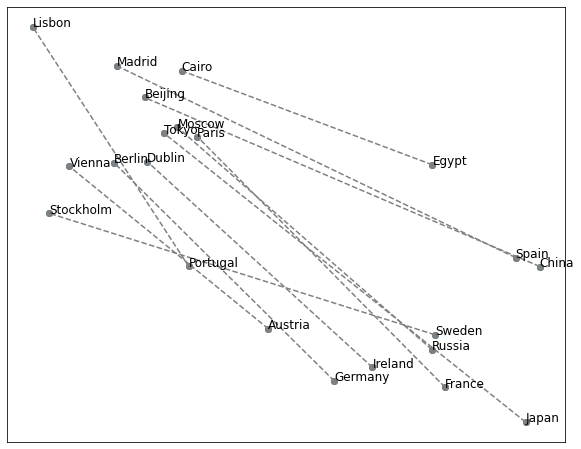

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vdf_[0], vdf_[1])

for ctr, (x, y) in vdf_.iterrows():
    ax.annotate(ctr, (x, y), fontsize=12)

for k, v in ctr2cptl.items():
    ax.plot(vdf_.loc[[k, v], 0], vdf_.loc[[k, v], 1], 'ro--', color="grey")

ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
fig.savefig("Fig_13_1.jpg", bbox_inches='tight', dpi=300)

# 2. Masculine and feminine

In [21]:
f2m = {
    'sister': 'brother',
    'mother': 'father',
    'woman': 'man',
    'girl': 'boy',
    'queen': 'king',
    'princess': 'prince',
    'aunt': 'uncle',
    'niece': 'nephew',
}
word_list = list(f2m.keys()) + list(f2m.values())

# Fetch word embeddings from fasttext
vdf = pd.DataFrame.from_dict({
    w: ft.get_word_vector(w) for w in word_list
}, orient='index')

In [22]:
# Dimension reduction
METHOD = "projection"

if METHOD == "projection":
    X = np.column_stack([
        ft.get_word_vector("masculine"),
        ft.get_word_vector("feminine")
    ])

    proj = np.linalg.inv(X.T @ X) @ X.T
    vdf_ = vdf @ proj.T

elif METHOD == "SVD":
    tsvd = TruncatedSVD(n_components=2, n_iter=20, random_state=42)
    vdf_ = pd.DataFrame(tsvd.fit_transform(vdf), index=vdf.index)

elif METHOD == "tSNE":
    tsne = TSNE(init="pca")
    vdf_ = pd.DataFrame(tsne.fit_transform(vdf), index=vdf.index)


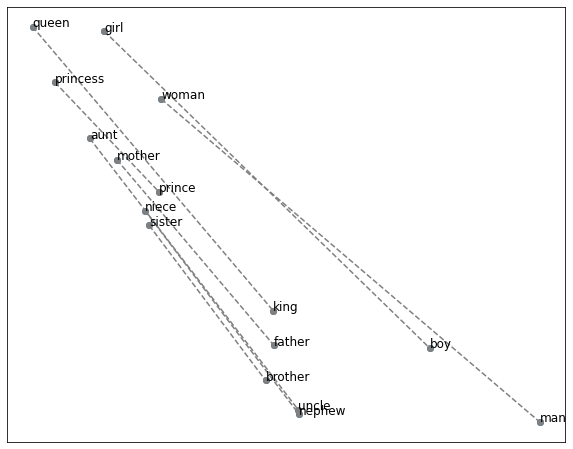

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vdf_[0], vdf_[1])

for ctr, (x, y) in vdf_.iterrows():
    ax.annotate(ctr, (x, y), fontsize=12)

for k, v in f2m.items():
    ax.plot(vdf_.loc[[k, v], 0], vdf_.loc[[k, v], 1], 'ro--', color="grey")

ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
fig.savefig("Fig_13_2.jpg", bbox_inches='tight', dpi=300)

# 3. Social class and gender

In [24]:
# Gender axis
f2m = {
    'sister': 'brother',
    'mother': 'father',
    'woman': 'man',
    'girl': 'boy',
    'women': 'men',
    'girls': 'boys',
    'female': 'male',
    'feminine': 'masculine'
}
gender_axis = (
    np.column_stack([ft.get_word_vector(w) for w in f2m.keys()]).mean(axis=1)
    - np.column_stack([ft.get_word_vector(w) for w in f2m.values()]).mean(axis=1)
)

In [25]:
# Gender axis
r2p = {
    'rich': 'poor',
    'wealth': 'poverty',
    'luxury': 'deprivation',
    'expansive': 'cheap',
    'abundance': 'need',
    'opulence': 'destitution',
    'prosperity': 'misery',
    'profusion': 'lack'
}

class_axis = (
    np.column_stack([ft.get_word_vector(w) for w in r2p.keys()]).mean(axis=1)
    - np.column_stack([ft.get_word_vector(w) for w in r2p.values()]).mean(axis=1)
)

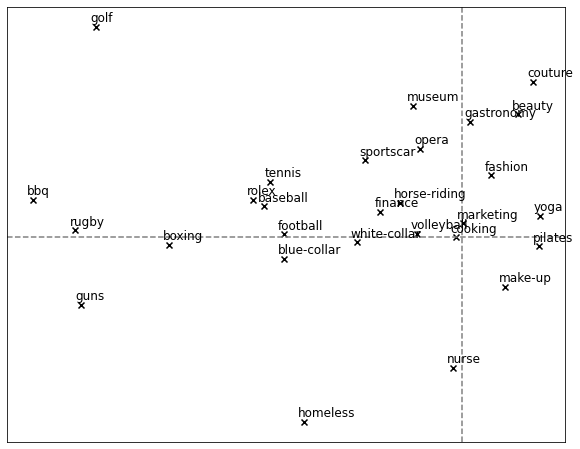

In [35]:
activity_list = [
    'football', 'rugby', 'boxing',
    'yoga', 'golf',
    'horse-riding', 'couture', 'tennis',
    'opera', 'museum', 'cooking',
    'beauty', 'rolex',
    'blue-collar', 'nurse', 'homeless',
    'sportscar', 'fashion',
    'bbq', 'guns', 'finance', 'marketing',
    'make-up', 'gastronomy', 'cooking',
    'white-collar', 'pilates', 'volleyball',
    'baseball'
]

# Fetch word embeddings from fasttext
vdf = pd.DataFrame.from_dict({
    w: ft.get_word_vector(w) for w in activity_list
}, orient='index')

X = np.c_[gender_axis, class_axis]

proj = np.linalg.inv(X.T @ X) @ X.T
vdf_ = vdf @ proj.T

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vdf_[0], vdf_[1], color="black", marker="x")
ax.axhline(y=0, color='grey', linestyle='--')
ax.axvline(x=0, color='grey', linestyle='--')

for ctr, (x, y) in vdf_.iterrows():
    ax.annotate(ctr, (x - .01, y + .01), fontsize=12)

ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
fig.savefig("Fig_13_3.jpg", bbox_inches='tight', dpi=300)